In [1]:
import time
import os

import numpy as np
import pandas as pd
import keras
from keras import layers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [2]:
max_words = 100000
max_len = 500
embedding_dim = 50
lstm_out = 200

In [3]:
file_train = 'batched3.json'

df_source = pd.read_json(file_train)
text = df_source['text'].values
df_source['label'] = df_source['categories'].apply(lambda x: x[0])
y = df_source['label'].values

sentences_train, sentences_test, categories_train, categories_test = train_test_split(text, y, test_size=0.25, random_state=1000)

In [4]:
tokenizer = Tokenizer(num_words=100000)
vectorizer_categories = CountVectorizer()
tokenizer.fit_on_texts(sentences_train)
vectorizer_categories.fit(categories_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
y_train = vectorizer_categories.transform(categories_train)
y_test = vectorizer_categories.transform(categories_test)

vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

In [5]:
X_train.shape

(12312, 500)

In [27]:
keras.backend.clear_session()

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                          output_dim=embedding_dim,
                          input_length=max_len))
#model.add(layers.Flatten())
#model.add(layers.GlobalMaxPool1D())
model.add(layers.LSTM(lstm_out, return_sequences=True, activation='softmax'))
model.add(layers.LSTM(lstm_out))
#model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(3, activation='relu'))
model.compile(loss='kullback_leibler_divergence',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 50)           6563600   
_________________________________________________________________
lstm_1 (LSTM)                (None, 500, 200)          200800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 603       
Total params: 7,085,803
Trainable params: 7,085,803
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.inputs

[<tf.Tensor 'embedding_1_input:0' shape=(?, 500) dtype=float32>]

In [ ]:
history = model.fit(X_train, y_train,
                   epochs=5,
                   validation_data=(X_test, y_test))

Train on 12312 samples, validate on 4105 samples
Epoch 1/5
 4960/12312 [===========>..................] - ETA: 6:06 - loss: 10.0100 - acc: 0.3831

In [12]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [13]:
loss, accuracy = model.evaluate(X_train, y_train)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test)
print("Testing Accuracy:  {:.4f}".format(accuracy))

12312/12312 [==============================] - 124s 10ms/step
Training Accuracy: 0.3830
4105/4105 [==============================] - 42s 10ms/step
Testing Accuracy:  0.3851


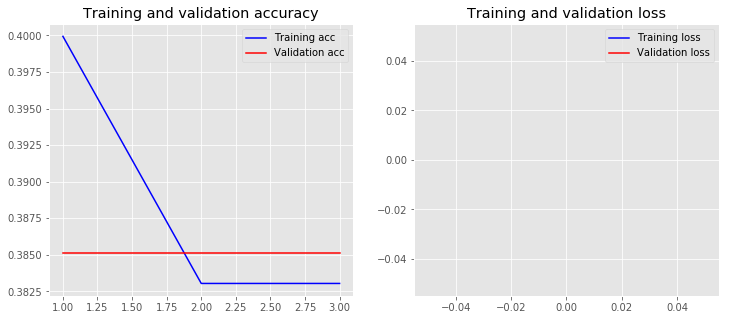

In [17]:
plot_history(model.history)

In [ ]:
df_test = pd.read_csv(data_dir + 'test_twitter_data.csv')
test = df_test['features'].values
test_twitter = tokenizer.texts_to_sequences(test)
test_twitter = pad_sequences(test_twitter, padding='post', maxlen=max_len)

test_one_twitter = tokenizer.texts_to_sequences([test[1]])
test_one_twitter = pad_sequences(test_one_twitter, padding='post', maxlen=max_len)

test_one_news = tokenizer.texts_to_sequences(["The legal action, filed in New York's Southern District, is against Deutsche Bank, one of Trump's lenders, and Capital One. Both banks \"have long provided business and personal banking services to Plaintiffs,\" Trump's attorneys said.\"The subpoenas were issued to harass President Donald J. Trump, to rummage through every aspect of his personal finances, his businesses, and the private information of the President and his family, and to ferret about for any material that might be used to cause him political damage. No grounds exist to establish any purpose other than a political one,\" Trump's attorneys wrote in the complaint filed late Monday."])
test_one_news = pad_sequences(test_one_news, padding='post', maxlen=max_len)

test_one_reddit = tokenizer.texts_to_sequences(["I paid a friend of mine some money to draw me a skin for Mercy I've always wanted. Yes, I know she's Swiss. No, I don't care. I wish it was a skin in game so I could ALWAYS USE IT. And against my better judgement I've posted it here to show off how good my friends art is. I hope y'all enjoy it, and if you don't, that's okay too ♥ Edit: She replied! https://www.instagram.com/jenv_arts/ and https://twitter.com/jenv_arts Enjoy everyone!"])
test_one_reddit = pad_sequences(test_one_reddit, padding='post', maxlen=max_len)

test_one_random = tokenizer.texts_to_sequences(["They dont need a product I've said it countless times there are groups that are just writing a report about analysing a data set using the exact same process we did in class Our product would be the code that cleaned and processed the data, the code that collected it, and hopefully if achievable the tensorflow program that trains a model to do something"])
test_one_random = pad_sequences(test_one_random, padding='post', maxlen=max_len)

In [ ]:
vectorizer_categories.vocabulary_

In [ ]:
prediction = model.predict(test_twitter)
i = 0
j = 0
for x in np.round(prediction, decimals=3):
    i = i + 1
    print(i)
    if x[2] < 0.80:
        j = j + 1
        print("[DING DONG]x" + str(j))
    print("News: " + str(np.format_float_positional(x[0], pad_right=3)) + " | Reddit: " + str(np.format_float_positional(x[1], pad_right=3)) + " | Twitter: " + str(np.format_float_positional(x[2], pad_right=3)) + "\n")

In [ ]:
prediction = model.predict(test_one_twitter)
for x in np.round(prediction, decimals=3):
    print("News: " + str(np.format_float_positional(x[0], pad_right=3)) + " | Reddit: " + str(np.format_float_positional(x[1], pad_right=3)) + " | Twitter: " + str(np.format_float_positional(x[2], pad_right=3)) + "\n")

In [ ]:
prediction = model.predict(test_one_news)
for x in np.round(prediction, decimals=3):
    print("News: " + str(np.format_float_positional(x[0], pad_right=3)) + " | Reddit: " + str(np.format_float_positional(x[1], pad_right=3)) + " | Twitter: " + str(np.format_float_positional(x[2], pad_right=3)) + "\n")

In [ ]:
prediction = model.predict(test_one_reddit)
for x in np.round(prediction, decimals=3):
    print("News: " + str(np.format_float_positional(x[0], pad_right=3)) + " | Reddit: " + str(np.format_float_positional(x[1], pad_right=3)) + " | Twitter: " + str(np.format_float_positional(x[2], pad_right=3)) + "\n")

In [ ]:
prediction = model.predict(test_one_random)
for x in np.round(prediction, decimals=3):
    print("News: " + str(np.format_float_positional(x[0], pad_right=3)) + " | Reddit: " + str(np.format_float_positional(x[1], pad_right=3)) + " | Twitter: " + str(np.format_float_positional(x[2], pad_right=3)) + "\n")